In [1]:
!pip install -U hiplot
!pip install keras-tuner

     |████████████████████████████████| 748 kB 1.2 MB/s 
     |████████████████████████████████| 357 kB 5.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import regularizer
from tensorflow.keras.regularizers import l2

#import keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel 

from keras.utils import np_utils

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
2.3.1


In [3]:
df = pd.read_csv("../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv")
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

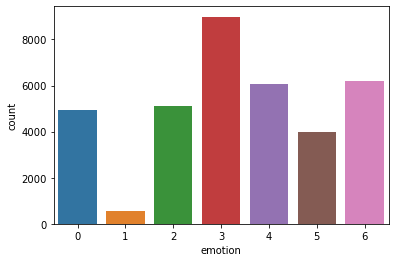

In [7]:
sns.countplot(df.emotion)
pyplot.show()

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

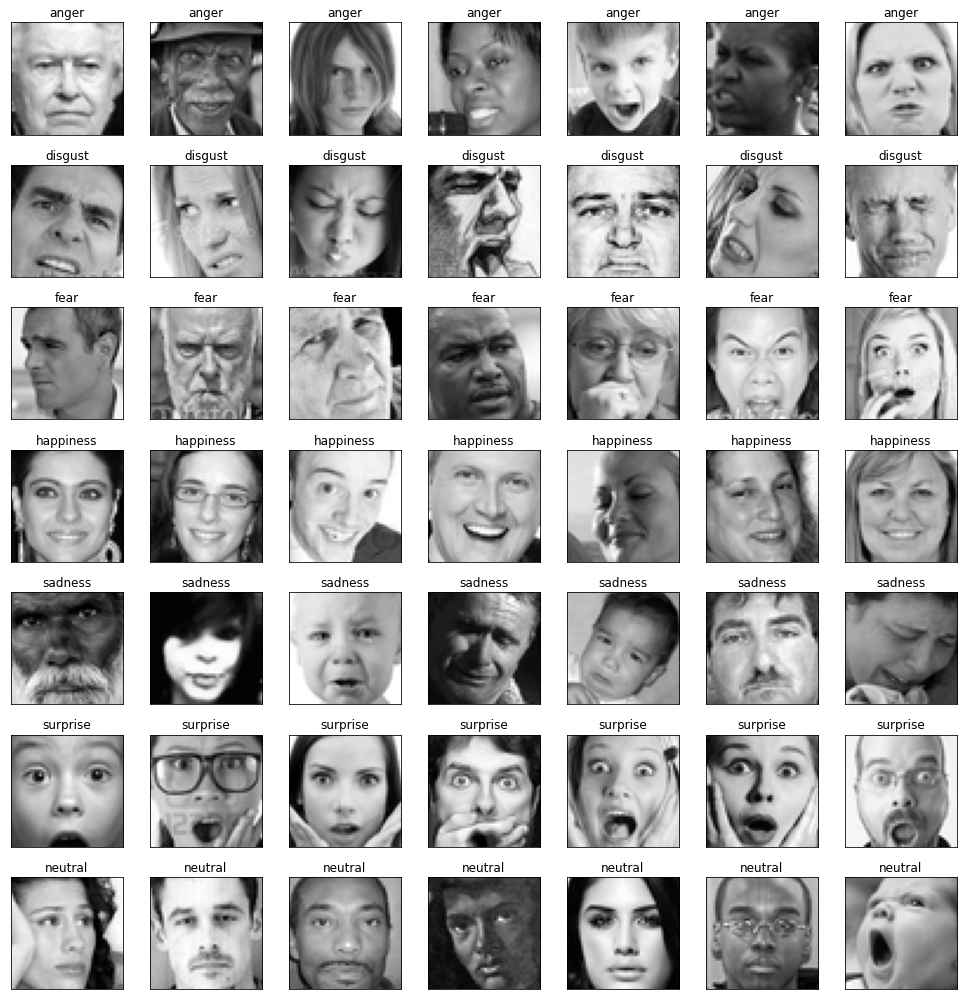

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
LOC=14
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[LOC]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        
        LOC += 1
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
# Here I combine Anger and Disgust. 
df['emotion'] = df['emotion'].replace([1],0)

In [11]:
INTERESTED_LABELS = [0, 2, 3, 4, 5, 6]

In [12]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.emotion.value_counts()

3    8989
6    6198
4    6077
0    5500
2    5121
5    4002
Name: emotion, dtype: int64

In [13]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [14]:
img_array.shape


(35887, 48, 48, 1)

In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 6)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 6), (3589, 6))

In [18]:
del df
del img_array
del img_labels

In [19]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [20]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [21]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [22]:
class FER_HyperModel(HyperModel):

    def __init__(self, classes):
        self.classes = classes
    
    def build(self, hp):
        net = Sequential(name='DCNN')

        net.add(
            Conv2D(
                filters = hp.Int('layer1_filter', 8, 64, 8),
                kernel_size=(5,5),
                input_shape=(img_width, img_height, img_depth),
                activation = hp.Choice('layer1_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_1'
            )
        )
        net.add(BatchNormalization(name='batchnorm_1'))
        net.add(
            Conv2D(
                filters=hp.Int('layer2_filter', 8, 64, 8),
                kernel_size=(5,5),
                activation=hp.Choice('layer2_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_2'
            )
        )
        net.add(BatchNormalization(name='batchnorm_2'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
        net.add(Dropout(0.4, name='dropout_1'))

        net.add(
            Conv2D(
                filters=hp.Int('layer3_filter', 16, 128, 16),
                kernel_size=(3,3),
                activation=hp.Choice('layer3_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_3'
            )
        )
        net.add(BatchNormalization(name='batchnorm_3'))
        net.add(
            Conv2D(
                filters=hp.Int('layer4_filter', 16, 128, 16),
                kernel_size=(3,3),
                activation=hp.Choice('layer4_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_4'
            )
        )
        net.add(BatchNormalization(name='batchnorm_4'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
        net.add(Dropout(0.4, name='dropout_2'))

        net.add(
            Conv2D(
                filters=hp.Int('layer5_filter', 32, 256, 32),
                kernel_size=(3,3),
                activation=hp.Choice('layer5_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_5'
            )
        )
        net.add(BatchNormalization(name='batchnorm_5'))
        net.add(
            Conv2D(
                filters=hp.Int('layer6_filter', 32, 256, 32),
                kernel_size=(3,3),
                activation=hp.Choice('layer6_activation', values=['elu', 'swish']),
                padding='same',
                kernel_initializer='he_normal',
                name='conv2d_6'
            )
        )
        net.add(BatchNormalization(name='batchnorm_6'))

        net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
        net.add(Dropout(0.5, name='dropout_3'))

        net.add(Flatten(name='flatten'))

        net.add(
            Dense(
                128,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
        net.add(BatchNormalization(name='batchnorm_7'))

        net.add(Dropout(0.6, name='dropout_4'))

        net.add(
            Dense(
                6,
                activation='softmax',
                name='out_layer'
            )
        )
        
        optim = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')

        net.compile(
            loss='categorical_crossentropy',
            optimizer=optim,
            metrics=['accuracy']
        )

        net.summary()

        return net
        

In [23]:
FERmodel = FER_HyperModel(classes=6)

In [24]:
tuner = RandomSearch(
    FERmodel,
    objective='val_accuracy',
    max_trials=20,
    directory='random_search',
    project_name='hjh_pp'
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 8)         208       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 8)         1608      
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 8)         32        
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        1168   

In [25]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=8,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [26]:
EPOCHS=100
tuner.search(X_train, y_train,
             epochs=EPOCHS,
             validation_data=(X_valid, y_valid),
             callbacks=callbacks)

tuner.results_summary()

Trial 20 Complete [00h 10m 20s]
val_accuracy: 0.685149073600769

Best val_accuracy So Far: 0.6932293176651001
Total elapsed time: 04h 06m 16s
Results summary
Results in random_search/hjh_pp
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer1_filter: 48
layer1_activation: elu
layer2_filter: 40
layer2_activation: swish
layer3_filter: 80
layer3_activation: elu
layer4_filter: 96
layer4_activation: elu
layer5_filter: 192
layer5_activation: swish
layer6_filter: 96
layer6_activation: swish
Score: 0.6932293176651001
Trial summary
Hyperparameters:
layer1_filter: 32
layer1_activation: elu
layer2_filter: 56
layer2_activation: swish
layer3_filter: 48
layer3_activation: elu
layer4_filter: 80
layer4_activation: elu
layer5_filter: 224
layer5_activation: swish
layer6_filter: 32
layer6_activation: swish
Score: 0.6918361783027649
Trial summary
Hyperparameters:
layer1_filter: 24
layer1_activation: elu
layer2_filter: 56
layer2_activation: elu
layer3

In [27]:
bestmodel = tuner.get_best_models(num_models=1)[0]

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 48)        1248      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 40)        48040     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 40)        160       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 40)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 80)        28880  

In [28]:
model_json = bestmodel.to_json()
with open("model6.json", "w") as json_file:
    json_file.write(model_json)

bestmodel.save_weights("model6.h5")

In [29]:
import json

vis_data = []
rootdir = 'random_search/hjh_pp'
for subdirs, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith("trial.json"):
            with open(subdirs + '/' + file, 'r') as json_file:
                data = json_file.read()
            vis_data.append(json.loads(data))

In [30]:
import hiplot as hip

data = [{'layer1_filter': vis_data[idx]['hyperparameters']['values']['layer1_filter'],
         'layer1_activation': vis_data[idx]['hyperparameters']['values']['layer1_activation'],
         'layer2_filter': vis_data[idx]['hyperparameters']['values']['layer2_filter'], 
         'layer2_activation': vis_data[idx]['hyperparameters']['values']['layer2_activation'],
         'layer3_filter': vis_data[idx]['hyperparameters']['values']['layer3_filter'], 
         'layer3_activation': vis_data[idx]['hyperparameters']['values']['layer3_activation'],
         'layer4_filter': vis_data[idx]['hyperparameters']['values']['layer4_filter'], 
         'layer4_activation': vis_data[idx]['hyperparameters']['values']['layer4_activation'],
         'layer5_filter': vis_data[idx]['hyperparameters']['values']['layer5_filter'], 
         'layer5_activation': vis_data[idx]['hyperparameters']['values']['layer5_activation'],
         'layer6_filter': vis_data[idx]['hyperparameters']['values']['layer6_filter'], 
         'layer6_activation': vis_data[idx]['hyperparameters']['values']['layer6_activation'],
         
         'loss': vis_data[idx]['metrics']['metrics']['loss']['observations'][0]['value'],  
         'val_loss': vis_data[idx]['metrics']['metrics']['val_loss']['observations'][0]['value'], 
         'accuracy': vis_data[idx]['metrics']['metrics']['accuracy']['observations'][0]['value'],
         'val_accuracy': vis_data[idx]['metrics']['metrics']['val_accuracy']['observations'][0]['value']} for idx in range(10)]

hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

total wrong validation predictions: 1101


              precision    recall  f1-score   support

           0       0.66      0.64      0.65       550
           1       0.61      0.48      0.54       512
           2       0.86      0.87      0.86       899
           3       0.56      0.58      0.57       608
           4       0.77      0.82      0.80       400
           5       0.63      0.70      0.66       620

    accuracy                           0.69      3589
   macro avg       0.68      0.68      0.68      3589
weighted avg       0.69      0.69      0.69      3589



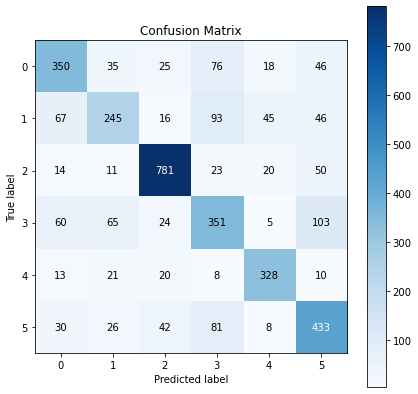

In [31]:
yhat_valid = bestmodel.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("FER confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [32]:
mapper = {
    0: "angry",
    1: "fear",
    2: "happy",
    3: "sad",
    4: "surprise",
    5: "neutral"
}

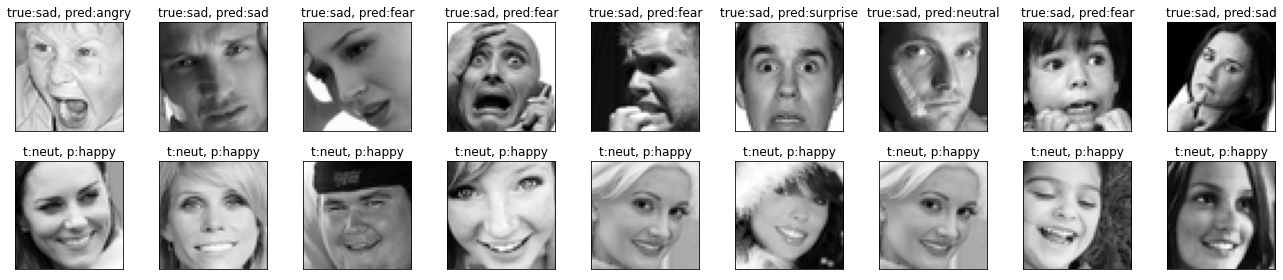

In [33]:
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[bestmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()
